In [12]:
import os, string

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype']        = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'

In [128]:
# Grab data from databases for plotting new and existing capacity
def _load_capacity(scen_labels_):

    # Load project capacity table and process them from database
    def __load_new_and_existing_csv(df_, scenario):

        df_['capacity_mw'] = df_['capacity_mw'].astype(float)
        df_['status']      = 'new'
        df_                = df_[['project', 
                                  'period', 
                                  'technology',
                                  'load_zone', 
                                  'status', 
                                  'capacity_mw', 
                                  'energy_capacity_mwh']]

        idx_  = (df_['period'] == 2020) & (df_['capacity_mw'] != 0.)
        df_.loc[capacity_['project'].isin(df_.loc[idx_, 'project'].unique()), 'status'] = 'existing'
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone', 
                           'status']).agg({'capacity_mw': 'sum', 'energy_capacity_mwh': 'sum'})

        df_ = df_.reset_index(drop = False).rename(columns = {'energy_capacity_mwh': 'capacity_mwh'})

        df_['scenario'] = scenario

        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        capacity_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        df_       = __load_new_and_existing_csv(capacity_, scen)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_dispatch(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_dispatch_from_csv(df_, scenario):
        
        df_['power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['power_mw']

        df_ = df_[['period', 'technology', 'load_zone', 'power_mw']]
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name  = r'{}/{}'.format(path, scen)
        dispatch_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_dispatch_from_csv(dispatch_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_transmission(scen_labels_):

    def __load_tx_losses_from_csv(df_, scenario):
        
        df_['transmission_losses_lz_to']   = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_to'] 
        df_['transmission_losses_lz_from'] = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_from']
        df_['transmission_flow_mw']        = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_flow_mw']

        df_1_               = df_[['period', 'load_zone_to', 'transmission_losses_lz_to']].copy()
        df_1_['technology'] = 'Tx_Losses'
        df_1_               = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
                                                      'load_zone_to': 'load_zone'})

        df_2_               = df_[['period', 'load_zone_from', 'transmission_losses_lz_from']].copy()
        df_2_['technology'] = 'Tx_Losses'
        df_2_               = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
                                                      'load_zone_from': 'load_zone'})
        
        df_3_ = df_[['period', 'load_zone_to', 'transmission_flow_mw']].copy()
        df_3_ = df_3_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_to': 'load_zone'})

        df_3_.loc[df_3_['power_mw'] >= 0., 'technology'] = 'Import'
        df_3_.loc[df_3_['power_mw'] < 0., 'technology']  = 'Export'
        
        df_4_ = df_[['period', 'load_zone_from', 'transmission_flow_mw']].copy()
        df_4_ = df_4_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_from': 'load_zone'})

        df_4_['power_mw'] = - df_4_['power_mw']

        df_4_.loc[df_4_['power_mw'] >= 0., 'technology'] = 'Import'
        df_4_.loc[df_4_['power_mw'] < 0., 'technology']  = 'Export'
        
        df_ = pd.concat([df_1_, df_2_, df_3_, df_4_], axis = 0)
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

def _load_demand(scen_labels_):
    
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
        
        df_['overgeneration_mw']  = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['overgeneration_mw']
        df_['unserved_energy_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['unserved_energy_mw']
        df_['power_mw']           = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['static_load_mw']

        df_1_               = df_[['period', 'load_zone', 'overgeneration_mw']].copy()
        df_1_['technology'] = 'Curtailment'                
        df_1_               = df_1_.rename(columns = {'overgeneration_mw': 'power_mw'})
        df_1_               = df_1_.groupby(['period', 
                                             'technology', 
                                             'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_2_               = df_[['period', 'load_zone', 'unserved_energy_mw']].copy()
        df_2_['technology'] = 'Shedding'                 
        df_2_               = df_2_.rename(columns = {'unserved_energy_mw': 'power_mw'})
        df_2_               = df_2_.groupby(['period', 
                                             'technology', 
                                             'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_3_               = df_[['period', 'load_zone', 'power_mw']].copy()
        df_3_['technology'] = 'Demand'                 
        df_3_               = df_3_
        df_3_               = df_3_.groupby(['period', 
                                             'technology', 
                                             'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_4_               = df_[['period', 'load_zone', 'total_power_mw']].copy()
        df_4_['technology'] = 'Peak'                 
        df_4_               = df_4_.rename(columns = {'total_power_mw': 'power_mw'})
        df_4_               = df_4_.groupby(['period', 
                                             'technology', 
                                             'load_zone']).agg({'power_mw': 'max'}).reset_index(drop = False)
        
        df_ = pd.concat([df_1_, df_2_, df_3_, df_4_], axis = 0).reset_index(drop = True)

        df_['scenario'] = scenario
                                  
        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name = r'{}/{}'.format(path, scen)
        demand_  = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_demand_from_csv(demand_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting energy targets
def _load_energy_target(scen_labels_):

    # Load project capacity table and process them from database
    def __load_energy_target_csv(df_, scenario):
        
        df_ = df_[['period',
                   'energy_target_zone',
                   'delivered_energy_target_energy_mwh',
                   'curtailed_energy_target_energy_mwh',
                   'energy_target_mwh',
                   'total_energy_target_energy_mwh',
                   'energy_target_shortage_mwh']]
        
        df_ = df_.rename(columns = {'energy_target_zone': 'load_zone'})
        
        df_['scenario'] = scenario

        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name = r'{}/{}'.format(path, scen)
        rpo_     = pd.read_csv(dir_name + r'/results/system_period_energy_target.csv', low_memory = False)
        df_      = __load_energy_target_csv(rpo_, scen)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

In [5]:
def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status', 
                                   'scenario']).agg({'capacity_mw': 'sum', 
                                                     'capacity_mwh': 'sum'})

    return capacity_.reset_index(drop = False)

def _group_dispatch_technologies(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        df_.loc[df_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'power_mw': 'sum'})

    return df_.reset_index(drop = False)

In [141]:
def _plot_new_and_existing_capacity_by_zone(ax, df_1_, df_2_, tech_label_, scen, period,
                                            y_lim       = 10,
                                            units       = 1e3,
                                            units_label = 'Existing & New Capacity (GW)',
                                            legend      = True,
                                            title       = ''):

    def __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'capacity_mw'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech,
                                       zorder = 10)
 
    zones_       = df_1_['load_zone'].unique()
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    offset = 0
    y_max  = 0
    
    width  = .75
    x_     = np.linspace(0, len(zones_) - 1, len(zones_))

    df_p_  = df_1_.loc[(df_1_['scenario'] == scen) & (df_1_['period'] == period)].copy()
    df_pp_ = df_2_.loc[(df_2_['scenario'] == scen) & (df_2_['period'] == period) & (df_2_['technology'] == 'Peak')].copy()

    __make_new_and_existing_capacit_legend(df_p_, techs_, colors_, ax)
    
    for zone, i_zone in zip(zones_, range(len(zones_))):

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = (df_p_['load_zone'] == zone) & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

            if idx_.sum() == 1.:
                power = df_p_.loc[idx_, 'capacity_mw'].to_numpy()[0]
                color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                ax.bar(x_[i_zone], power/units, width, bottom    = offset/units,
                                                         color     = color,
                                                         lw        = 0.,
                                                         hatch     = 'x',
                                                         edgecolor = 'lightgray', 
                                                         zorder    = 5)
                
                offset += power

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = (df_p_['load_zone'] == zone) & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
            if idx_.sum() == 1.:
                power = df_p_.loc[idx_, 'capacity_mw'].to_numpy()[0]
                color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                ax.bar(x_[i_zone], power/units, width, bottom = offset/units,
                                                       color  = color,
                                                       zorder = 5)

                offset += power

                if y_max < offset:
                    y_max = offset
                    
        power = df_pp_.loc[df_pp_['load_zone'] == zone, 'power_mw'].to_numpy()[0]
        if i_zone == 0:
            ax.plot(x_[i_zone], power/units, marker          = 'o', 
                                             c               = 'white', 
                                             label           = 'Peak (MW)',
                                             zorder          = 6,
                                             markeredgecolor = 'k')
        else:
            ax.plot(x_[i_zone], power/units, marker          = 'o', 
                                             c               = 'white', 
                                             zorder          = 6, 
                                             markeredgecolor = 'k')

        ticks_.append(x_[i_zone])
        labels_.append(zone.replace('_', ' '))
        offsets_.append(offset/units)
        x_period_.append(x_[i_zone])

        offset = 0.

        x_ = x_ + .9/len(zones_)

    ax.set_xticks(ticks_, labels_, rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 12, left = False)
    ax.set_ylabel(units_label, fontsize = 18)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    ax.set_ylim(-10., y_lim)

    ax.set_title(title, fontsize = 20)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
def _plot_dispatch_by_zone(ax, df_1_, df_2_, tech_label_, scen, period,
                           units       = 1e6,
                           y_lim_min   = - 10,
                           y_lim_max   = 10,
                           ylabel      = r'Electricity Generation (TWh)',
                           legend      = True,
                           title       = ''):

    def __make_dispatch_legend(data_, techs_, colors_, ax):
        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = data_['technology'] == tech
            if idx_.sum() > 0:
                if data_.loc[idx_, 'power_mw'].to_numpy().sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech.replace('_', ' '),
                                       zorder = 2,
                                       ec     = 'None',
                                       lw     = 0.,
                                       aa     = True)

    zones_       = df_1_['load_zone'].unique()
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    width = 0.75
    x_    = np.linspace(0, len(zones_) - 1, len(zones_))

    ticks_    = []
    labels_   = []
    x_period_ = []
    y_period_ = []
    
    i_scen          = 0
    offset_positive = 0.
    offset_negative = 0.    
    y_max           = 0
    y_min           = 0

    df_p_  = df_1_.loc[(df_1_['scenario'] == scen) & (df_1_['period'] == period)].copy()
    df_pp_ = df_2_.loc[(df_2_['scenario'] == scen) & (df_2_['period'] == period) & (df_2_['technology'] == 'Demand')].copy()

    __make_dispatch_legend(df_p_, techs_, colors_, ax)
    
    for zone, i_zone in zip(zones_, range(len(zones_))):

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = (df_p_['load_zone'] == zone) & (df_p_['technology'] == tech)

            if idx_.sum() == 1:
                power = float(df_p_.loc[idx_, 'power_mw'].to_numpy()[0])
                color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                if power != 0:
                    if power > 0:
                        offset = offset_positive
                    else:
                        offset = offset_negative

                    ax.bar(x_[i_zone], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 2,
                                                             ec     = 'None',
                                                             lw     = 0.,
                                                             aa     = True)

                    if power >= 0:
                        offset_positive += power
                    else:
                        offset_negative += power

        if offset_negative/units < y_min: 
            y_min = offset_negative/units
        if offset_positive/units > y_max: 
            y_max = offset_positive/units

        power = df_pp_.loc[df_pp_['load_zone'] == zone, 'power_mw'].to_numpy()[0]
        if i_zone == 0:
            ax.plot(x_[i_zone], power/units, marker          = 'o', 
                                             c               = 'white', 
                                             label           = 'Demand (MW)',
                                             zorder          = 6,
                                             markeredgecolor = 'k')
        else:
            ax.plot(x_[i_zone], power/units, marker          = 'o', 
                                             c               = 'white', 
                                             zorder          = 6, 
                                             markeredgecolor = 'k')
            
        ticks_.append(x_[i_zone])
        labels_.append(zone)
        x_period_.append(x_[i_zone])
        y_period_.append(offset_positive)

        offset_positive = 0.
        offset_negative = 0.

    x_ = x_ + .9/len(zones_)        

    ax.set_xticks(ticks_, [label.replace("_", " ") for label in labels_], rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 12, left = False)
    ax.set_ylabel(ylabel, fontsize = 18)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    ax.set_ylim(y_lim_min, y_lim_max)

    ax.set_title(title, fontsize = 18)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
def _plot_new_and_existing_storage_by_zone(ax, df_1_, df_2_, tech_label_, scen, period,
                                           units       = 1e3,
                                           y_lim       = 10,
                                           units_label = 'Existing & New Capacity (GW)',
                                           legend      = True,
                                           title       = ''):

    def __make_new_and_existing_storage_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'capacity_mwh'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech,
                                       zorder = 10)
 
    zones_       = df_1_['load_zone'].unique()
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    offset = 0
    y_max  = 0
    
    width  = .75
    x_     = np.linspace(0, len(zones_) - 1, len(zones_))

    df_p_  = df_1_.loc[(df_1_['scenario'] == scen) & (df_1_['period'] == period)].copy()
    df_pp_ = df_2_.loc[(df_2_['scenario'] == scen) & (df_2_['period'] == period) & (df_2_['technology'] == 'Peak')].copy()

    __make_new_and_existing_storage_legend(df_p_, techs_, colors_, ax)
    
    for zone, i_zone in zip(zones_, range(len(zones_))):

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = (df_p_['load_zone'] == zone) & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

            if idx_.sum() == 1.:
                power = df_p_.loc[idx_, 'capacity_mwh'].to_numpy()[0]
                color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                ax.bar(x_[i_zone], power/units, width, bottom    = offset/units,
                                                         color     = color,
                                                         lw        = 0.,
                                                         hatch     = 'x',
                                                         edgecolor = 'lightgray', 
                                                         zorder    = 5)
                
                offset += power

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = (df_p_['load_zone'] == zone) & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
            if idx_.sum() == 1.:
                power = df_p_.loc[idx_, 'capacity_mwh'].to_numpy()[0]
                color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                ax.bar(x_[i_zone], power/units, width, bottom = offset/units,
                                                       color  = color,
                                                       zorder = 5)

                offset += power

                if y_max < offset:
                    y_max = offset

        ticks_.append(x_[i_zone])
        labels_.append(zone.replace('_', ' '))
        offsets_.append(offset/units)
        x_period_.append(x_[i_zone])

        offset = 0.

        x_ = x_ + .9/len(zones_)
        

    ax.set_xticks(ticks_, labels_, rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 12, left = False)
    ax.set_ylabel(units_label, fontsize = 18)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    ax.set_ylim(-.5, y_lim)

    ax.set_title(title, fontsize = 20)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
def _plot_energy_target(ax, df_, scen, period,
                        y_lim_max = 800,
                        title  = '',
                        ylabel = 'Clean Energy Generation (TWh)' ,
                        units  = 1e6, 
                        legend = True):

    width = 0.8

    idx_  = (df_['period'] == period) & (df_['scenario'] == scen)
    df_p_ = df_.loc[idx_].reset_index(drop = True)

    zones_    = df_p_['load_zone'].to_numpy()
    shortage_ = df_p_['energy_target_shortage_mwh'].to_numpy()
    target_   = df_p_['energy_target_mwh'].to_numpy()
    energy_   = df_p_['total_energy_target_energy_mwh'].to_numpy()
    
    x_ = np.linspace(0, len(zones_) - 1, len(zones_))

    ax.bar(x_, energy_/units, width, 
           color  = '#92918b',
           bottom = 0., 
           label  = 'Delivered',
           lw     = 0.,
           zorder = 3)

    ax.bar(x_, (target_ - shortage_)/units, width, 
           color  = '#136564', 
           label  = 'RPO', 
           bottom = 0.,
           lw     = 0.,
           zorder = 5)

    ax.bar(x_, target_/units, width, 
           color  = '#900C3F', 
           bottom = 0., 
           label  = 'Shortage',
           lw     = 0.,
           zorder = 4)

    ax.set_xticks(x_, [zone.replace("_", " ") for zone in zones_], rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 12, left = False)
    ax.set_ylabel(ylabel, fontsize = 18)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if legend:
        ax.legend(loc     = 'upper right',
                  frameon = False,
                  prop    = {'size': 14})

    ax.set_ylim(-1., y_lim_max)

    ax.set_title(title, fontsize = 20)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

In [7]:
scen_labels_ = pd.read_csv(path_to_csvs + 'cost_scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + 'technology_labels.csv') 
zone_labels_ = pd.read_csv(path_to_csvs + 'zone_labels.csv') 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvscost_scenario_labels.csv'

# New and Existing Capacity at Zone Level

In [ ]:
demand_         = _load_demand(scen_labels_)
capacity_       = _load_capacity(scen_labels_)
group_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power

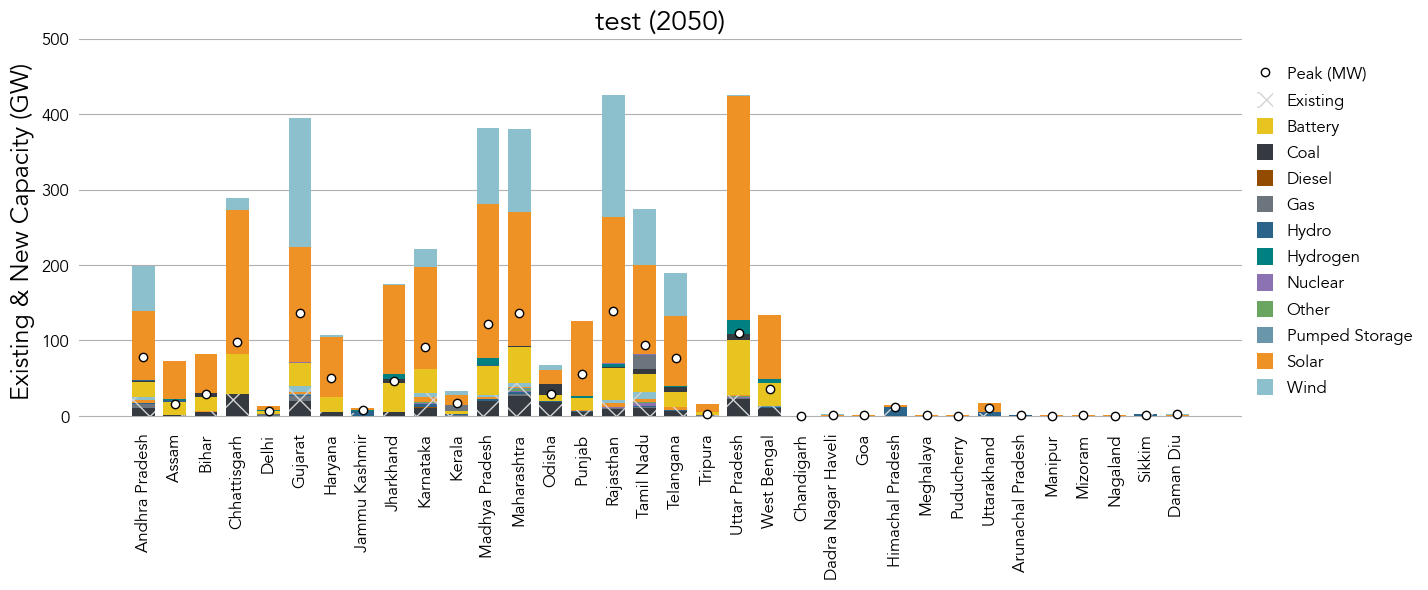

In [72]:
period     = 2050
scen       = 'VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid'
scen_label = 'test'

fig = plt.figure(figsize = (15, 5))
_ax = plt.subplot(111)

_plot_new_and_existing_capacity_by_zone(_ax, group_capacity_, demand_, tech_labels_, scen, period,
                                        y_lim       = 500,
                                        title       = f'{scen_label} ({period})',
                                        units_label = 'Existing & New Capacity (GW)')

plt.savefig(path_to_images + f'/{scen}-{period}-zone_installed_mw-bar_plots.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

# Generation at Zone Level

In [ ]:
demand_         = _load_demand(scen_labels_)
dispatch_       = _load_dispatch(scen_labels_)
group_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)
transmission_   = _load_transmission(scen_labels_)
group_dispatch_ = pd.concat([group_dispatch_, 
                             transmission_], axis = 0).reset_index(drop = True)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power

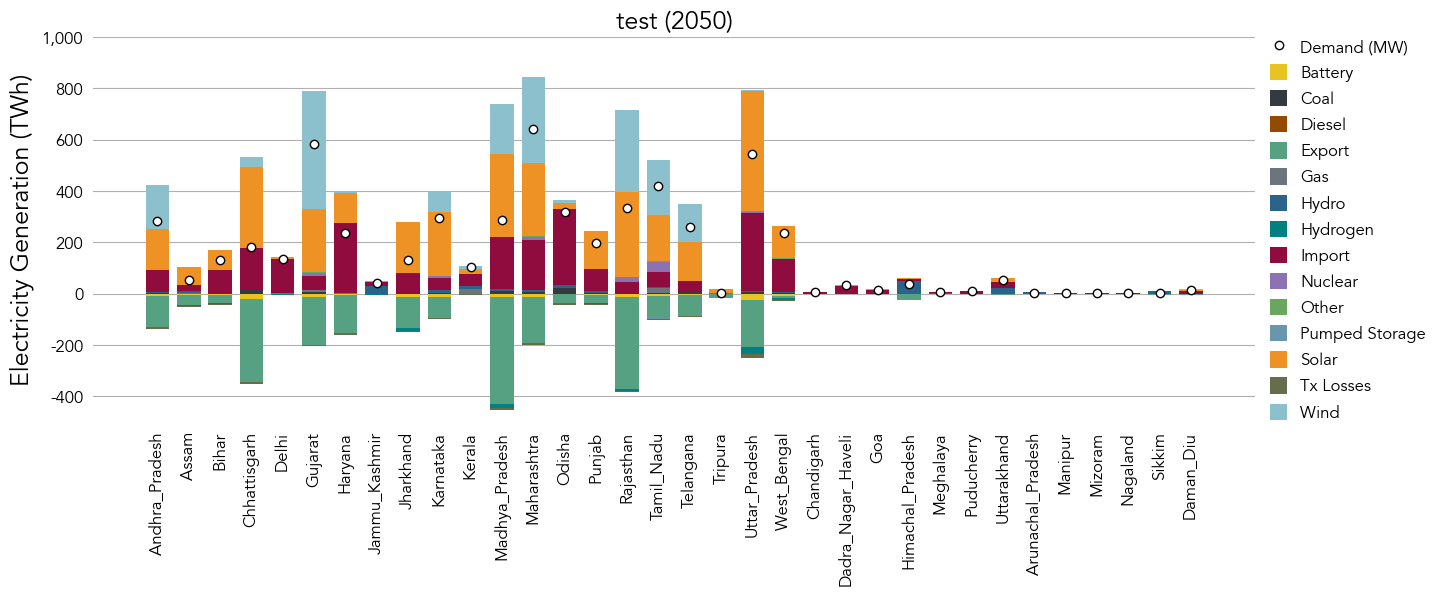

In [73]:
period     = 2050
scen       = 'VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid'
scen_label = 'test'

fig = plt.figure(figsize = (15, 5))
_ax = plt.subplot(111)

_plot_dispatch_by_zone(_ax, group_dispatch_, demand_, tech_labels_, scen, period, 
                       y_lim_min   = -500,
                       y_lim_max   = 1000,
                       title       = f'{scen_label} ({period})',
                       units_label = 'Electricity Generation (TWh)')

plt.savefig(path_to_images + f'/{scen}-{period}-zone_dispatch_mwh-bar_plots.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

# Storage Capacity at Zone Level

In [ ]:
capacity_       = _load_capacity(scen_labels_)
group_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


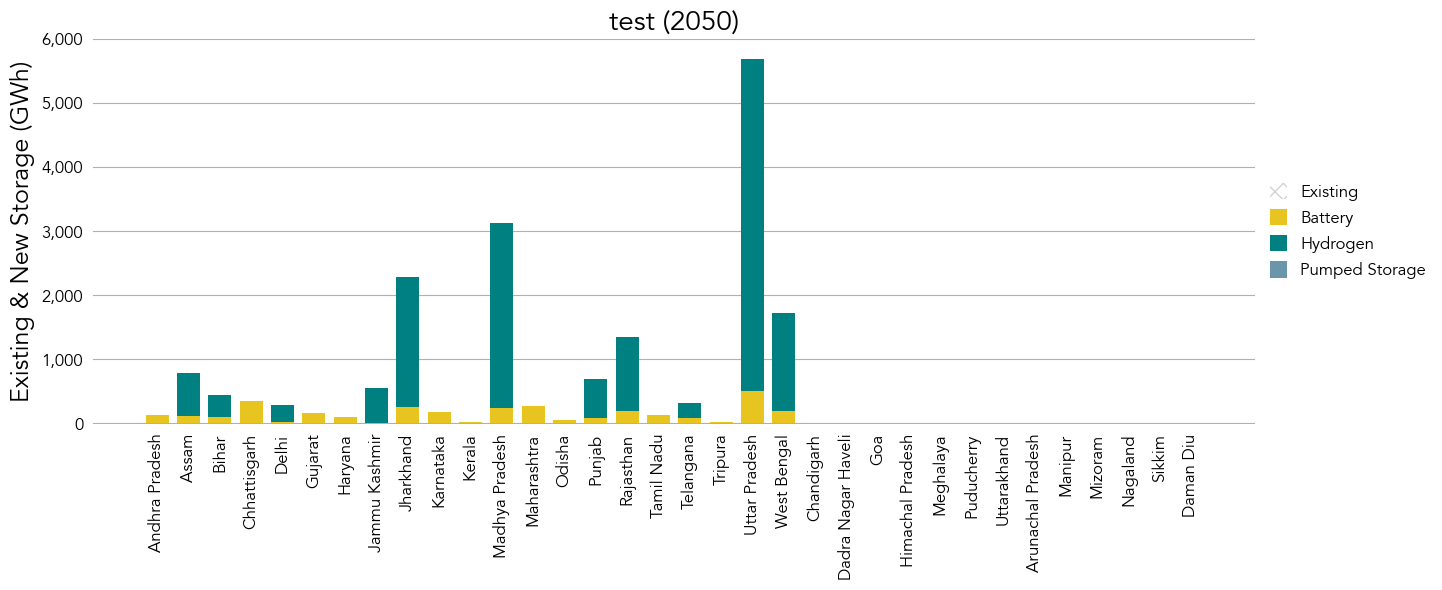

In [74]:
period     = 2050
scen       = 'VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid'
scen_label = 'test'

fig = plt.figure(figsize = (15, 5))
_ax = plt.subplot(111)

_plot_new_and_existing_storage_by_zone(_ax, group_capacity_, demand_, tech_labels_, scen, period,
                                       y_lim       = 6000,
                                       title       = f'{scen_label} ({period})',
                                       units_label = 'Existing & New Storage (GWh)')

plt.savefig(path_to_images + f'/{scen}-{period}-zone_installed_mwh-bar_plots.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

# Mosaic

In [66]:
demand_         = _load_demand(scen_labels_)
capacity_       = _load_capacity(scen_labels_)
group_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power

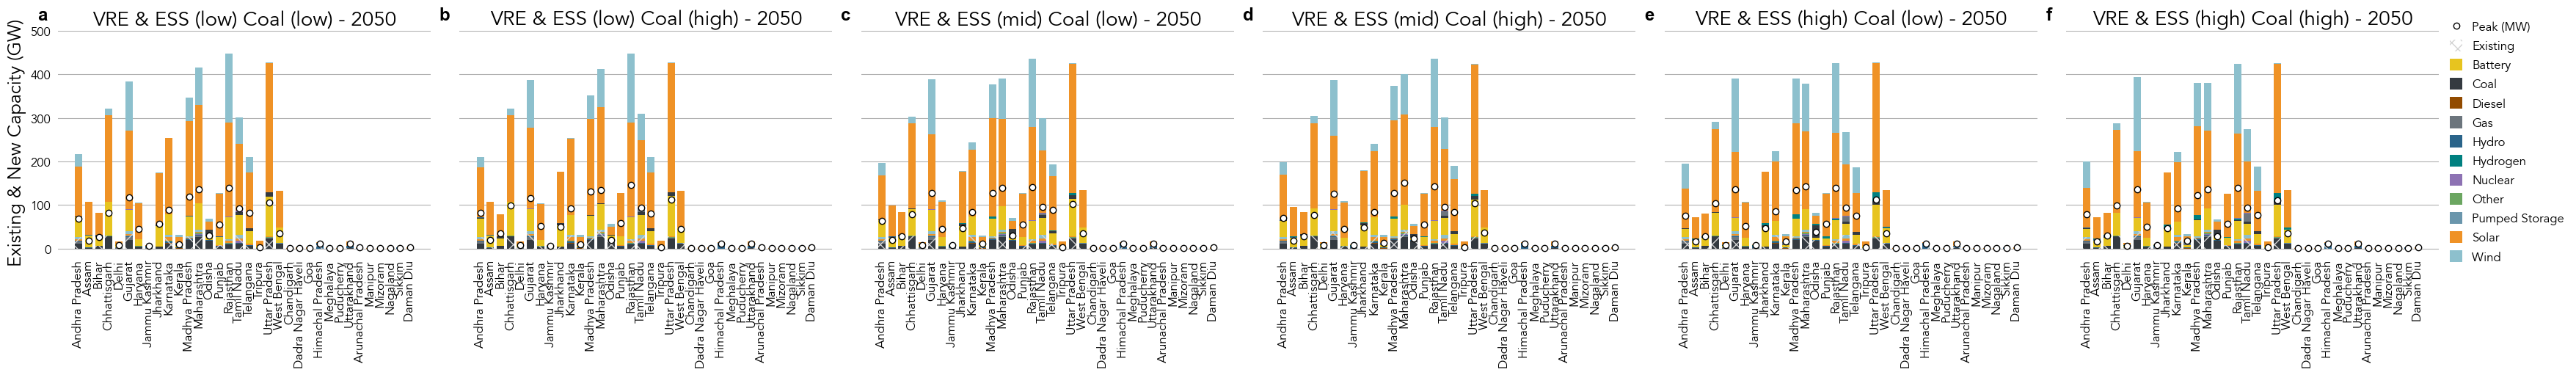

In [75]:
period  = 2050
scens_  = scen_labels_['scenario']
labels_ = scen_labels_['label']

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd', 'e', 'f']], layout      = 'constrained', 
                                                                sharey      = True,
                                                                figsize     = (35, 5), 
                                                                gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

i = 0

_plot_new_and_existing_capacity_by_zone(_ax['a'], group_capacity_, demand_, tech_labels_, scens_[i], period,
                                        title       = f'{labels_[i]} - {period}',
                                        units_label = 'Existing & New Capacity (GW)', 
                                        y_lim       = 500,
                                        legend      = False)
i += 1

for ax in [ax for label, ax in _ax.items()][1:-1]:
    _plot_new_and_existing_capacity_by_zone(ax, group_capacity_, demand_, tech_labels_, scens_[i], period,
                                            title       = f'{labels_[i]} - {period}',
                                            units_label = '', 
                                            y_lim       = 500,
                                            legend      = False)
    i += 1

_plot_new_and_existing_capacity_by_zone(_ax['f'], group_capacity_, demand_, tech_labels_, scens_[i], period,
                                        title       = f'{labels_[i]} - {period}',
                                        units_label = '',                                        
                                        y_lim       = 500,
                                        legend      = True)

plt.savefig(path_to_images + f'/{period}-zone_installed_mw-bar_plots.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [ ]:
demand_         = _load_demand(scen_labels_)
dispatch_       = _load_dispatch(scen_labels_)
group_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)
transmission_   = _load_transmission(scen_labels_)
group_dispatch_ = pd.concat([group_dispatch_, transmission_], axis = 0).reset_index(drop = True)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power

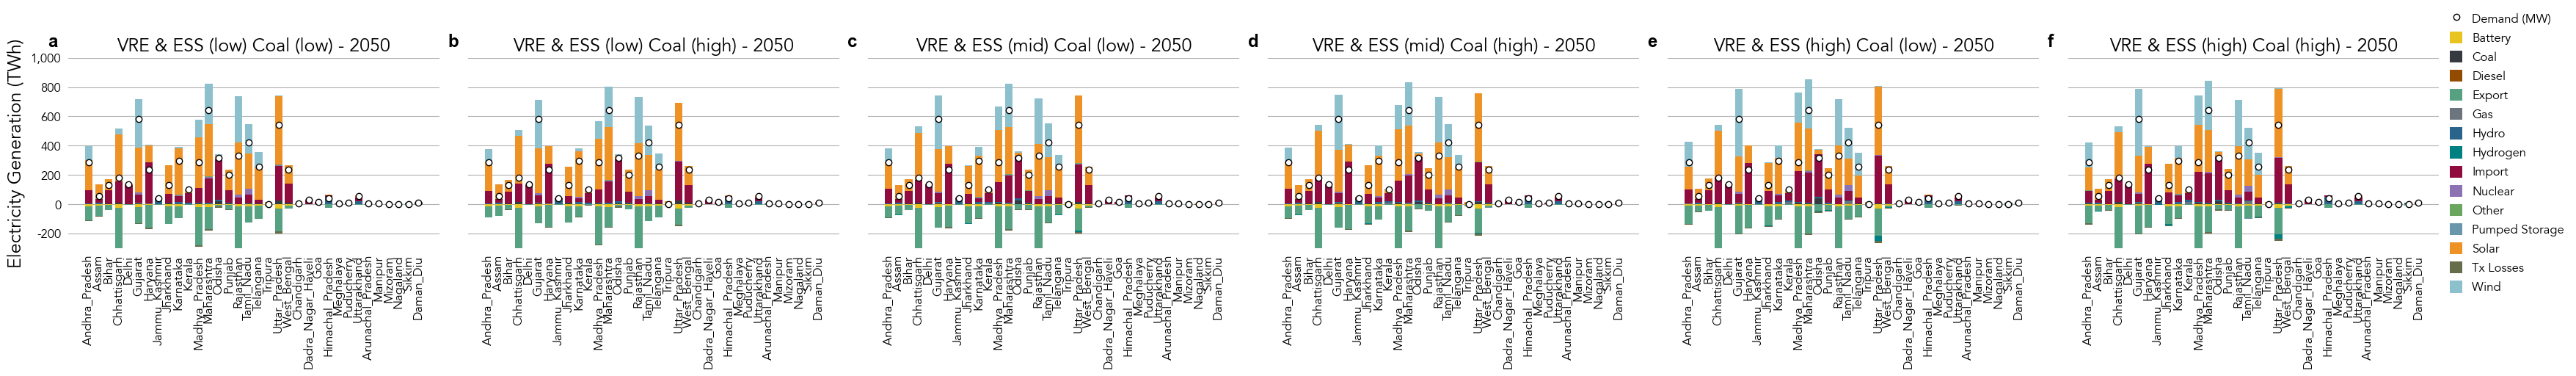

In [76]:
fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd', 'e', 'f']], layout      = 'constrained', 
                                                                sharey      = True,
                                                                figsize     = (35, 5), 
                                                                gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

i = 0

_plot_dispatch_by_zone(_ax['a'], group_dispatch_, demand_, tech_labels_, scens_[i], period,
                       title       = f'{labels_[i]} - {period}',
                       y_lim_min   = -300,
                       y_lim_max   = 1000,
                       legend      = False,
                       units_label = 'Electricity Generation (TWh)')

i += 1

for ax in [ax for label, ax in _ax.items()][1:-1]:
    _plot_dispatch_by_zone(ax, group_dispatch_, demand_, tech_labels_, scens_[i], period,
                           title       = f'{labels_[i]} - {period}',
                           y_lim_min   = -300,
                           y_lim_max   = 1000,
                           legend      = False,
                           units_label = '')
    i += 1

_plot_dispatch_by_zone(_ax['f'], group_dispatch_, demand_, tech_labels_, scens_[i], period,
                       title       = f'{labels_[i]} - {period}',
                       y_lim_min   = -300,
                       y_lim_max   = 1000,
                       legend      = True,
                       units_label = '')

plt.savefig(path_to_images + f'/{period}-zone_dispatch_mwh-bar_plots.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [ ]:
demand_         = _load_demand(scen_labels_)
capacity_       = _load_capacity(scen_labels_)
group_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power

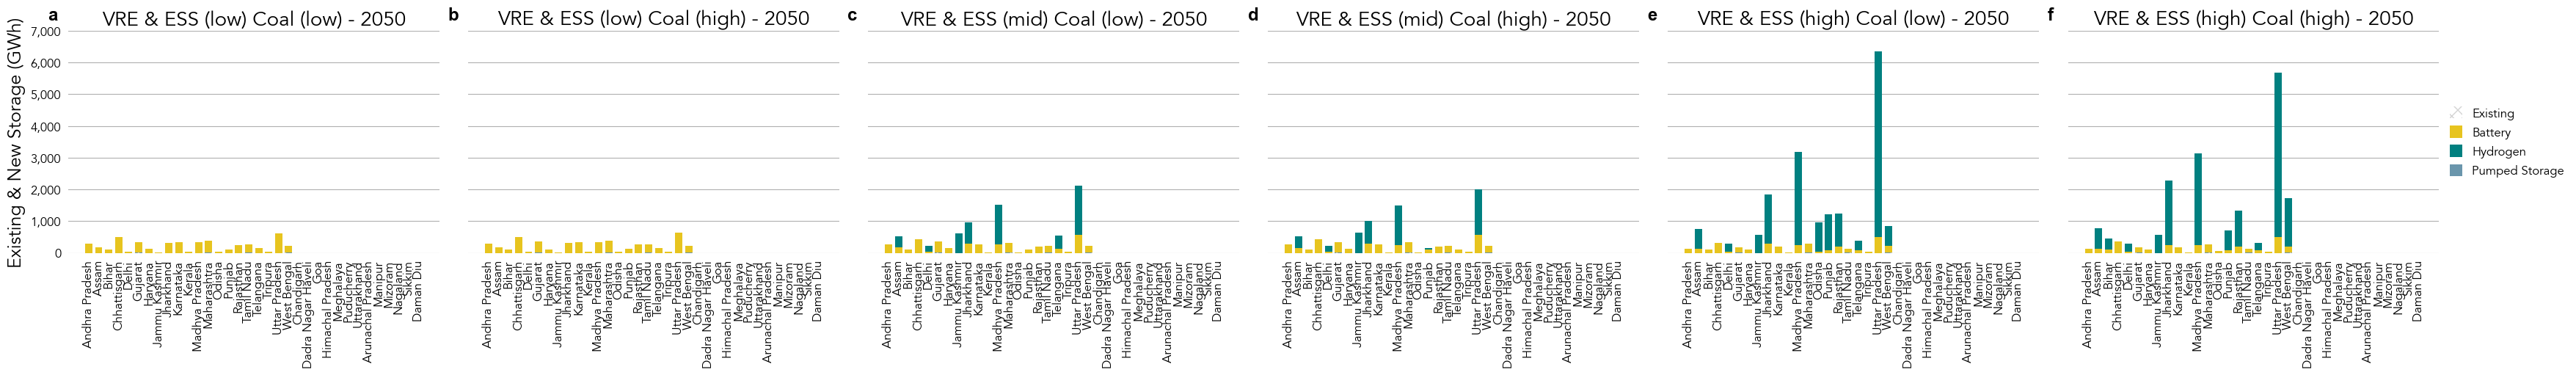

In [77]:
fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd', 'e', 'f']], layout      = 'constrained', 
                                                                sharey      = True,
                                                                figsize     = (35, 5), 
                                                                gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

i = 0

_plot_new_and_existing_storage_by_zone(_ax['a'], group_capacity_, demand_, tech_labels_, scens_[i], period,
                                        title       = f'{labels_[i]} - {period}',
                                        units_label = 'Existing & New Storage (GWh)', 
                                        y_lim       = 7000,
                                        legend      = False)
i += 1

for ax in [ax for label, ax in _ax.items()][1:-1]:
    _plot_new_and_existing_storage_by_zone(ax, group_capacity_, demand_, tech_labels_, scens_[i], period,
                                            title       = f'{labels_[i]} - {period}',
                                            units_label = '', 
                                            y_lim       = 7000,
                                            legend      = False)
    i += 1

_plot_new_and_existing_storage_by_zone(_ax['f'], group_capacity_, demand_, tech_labels_, scens_[i], period,
                                        title       = f'{labels_[i]} - {period}',
                                        units_label = '',                                        
                                        y_lim       = 7000,
                                        legend      = True)

plt.savefig(path_to_images + f'/{period}-zone_installed_mwh-bar_plots.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [ ]:
demand_         = _load_demand(scen_labels_)
dispatch_       = _load_dispatch(scen_labels_)
group_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)
transmission_   = _load_transmission(scen_labels_)
group_dispatch_ = pd.concat([group_dispatch_, transmission_], axis = 0).reset_index(drop = True)
group_dispatch_ = group_dispatch_.loc[group_dispatch_['load_zone'].isin(zones_)].reset_index(drop = True)

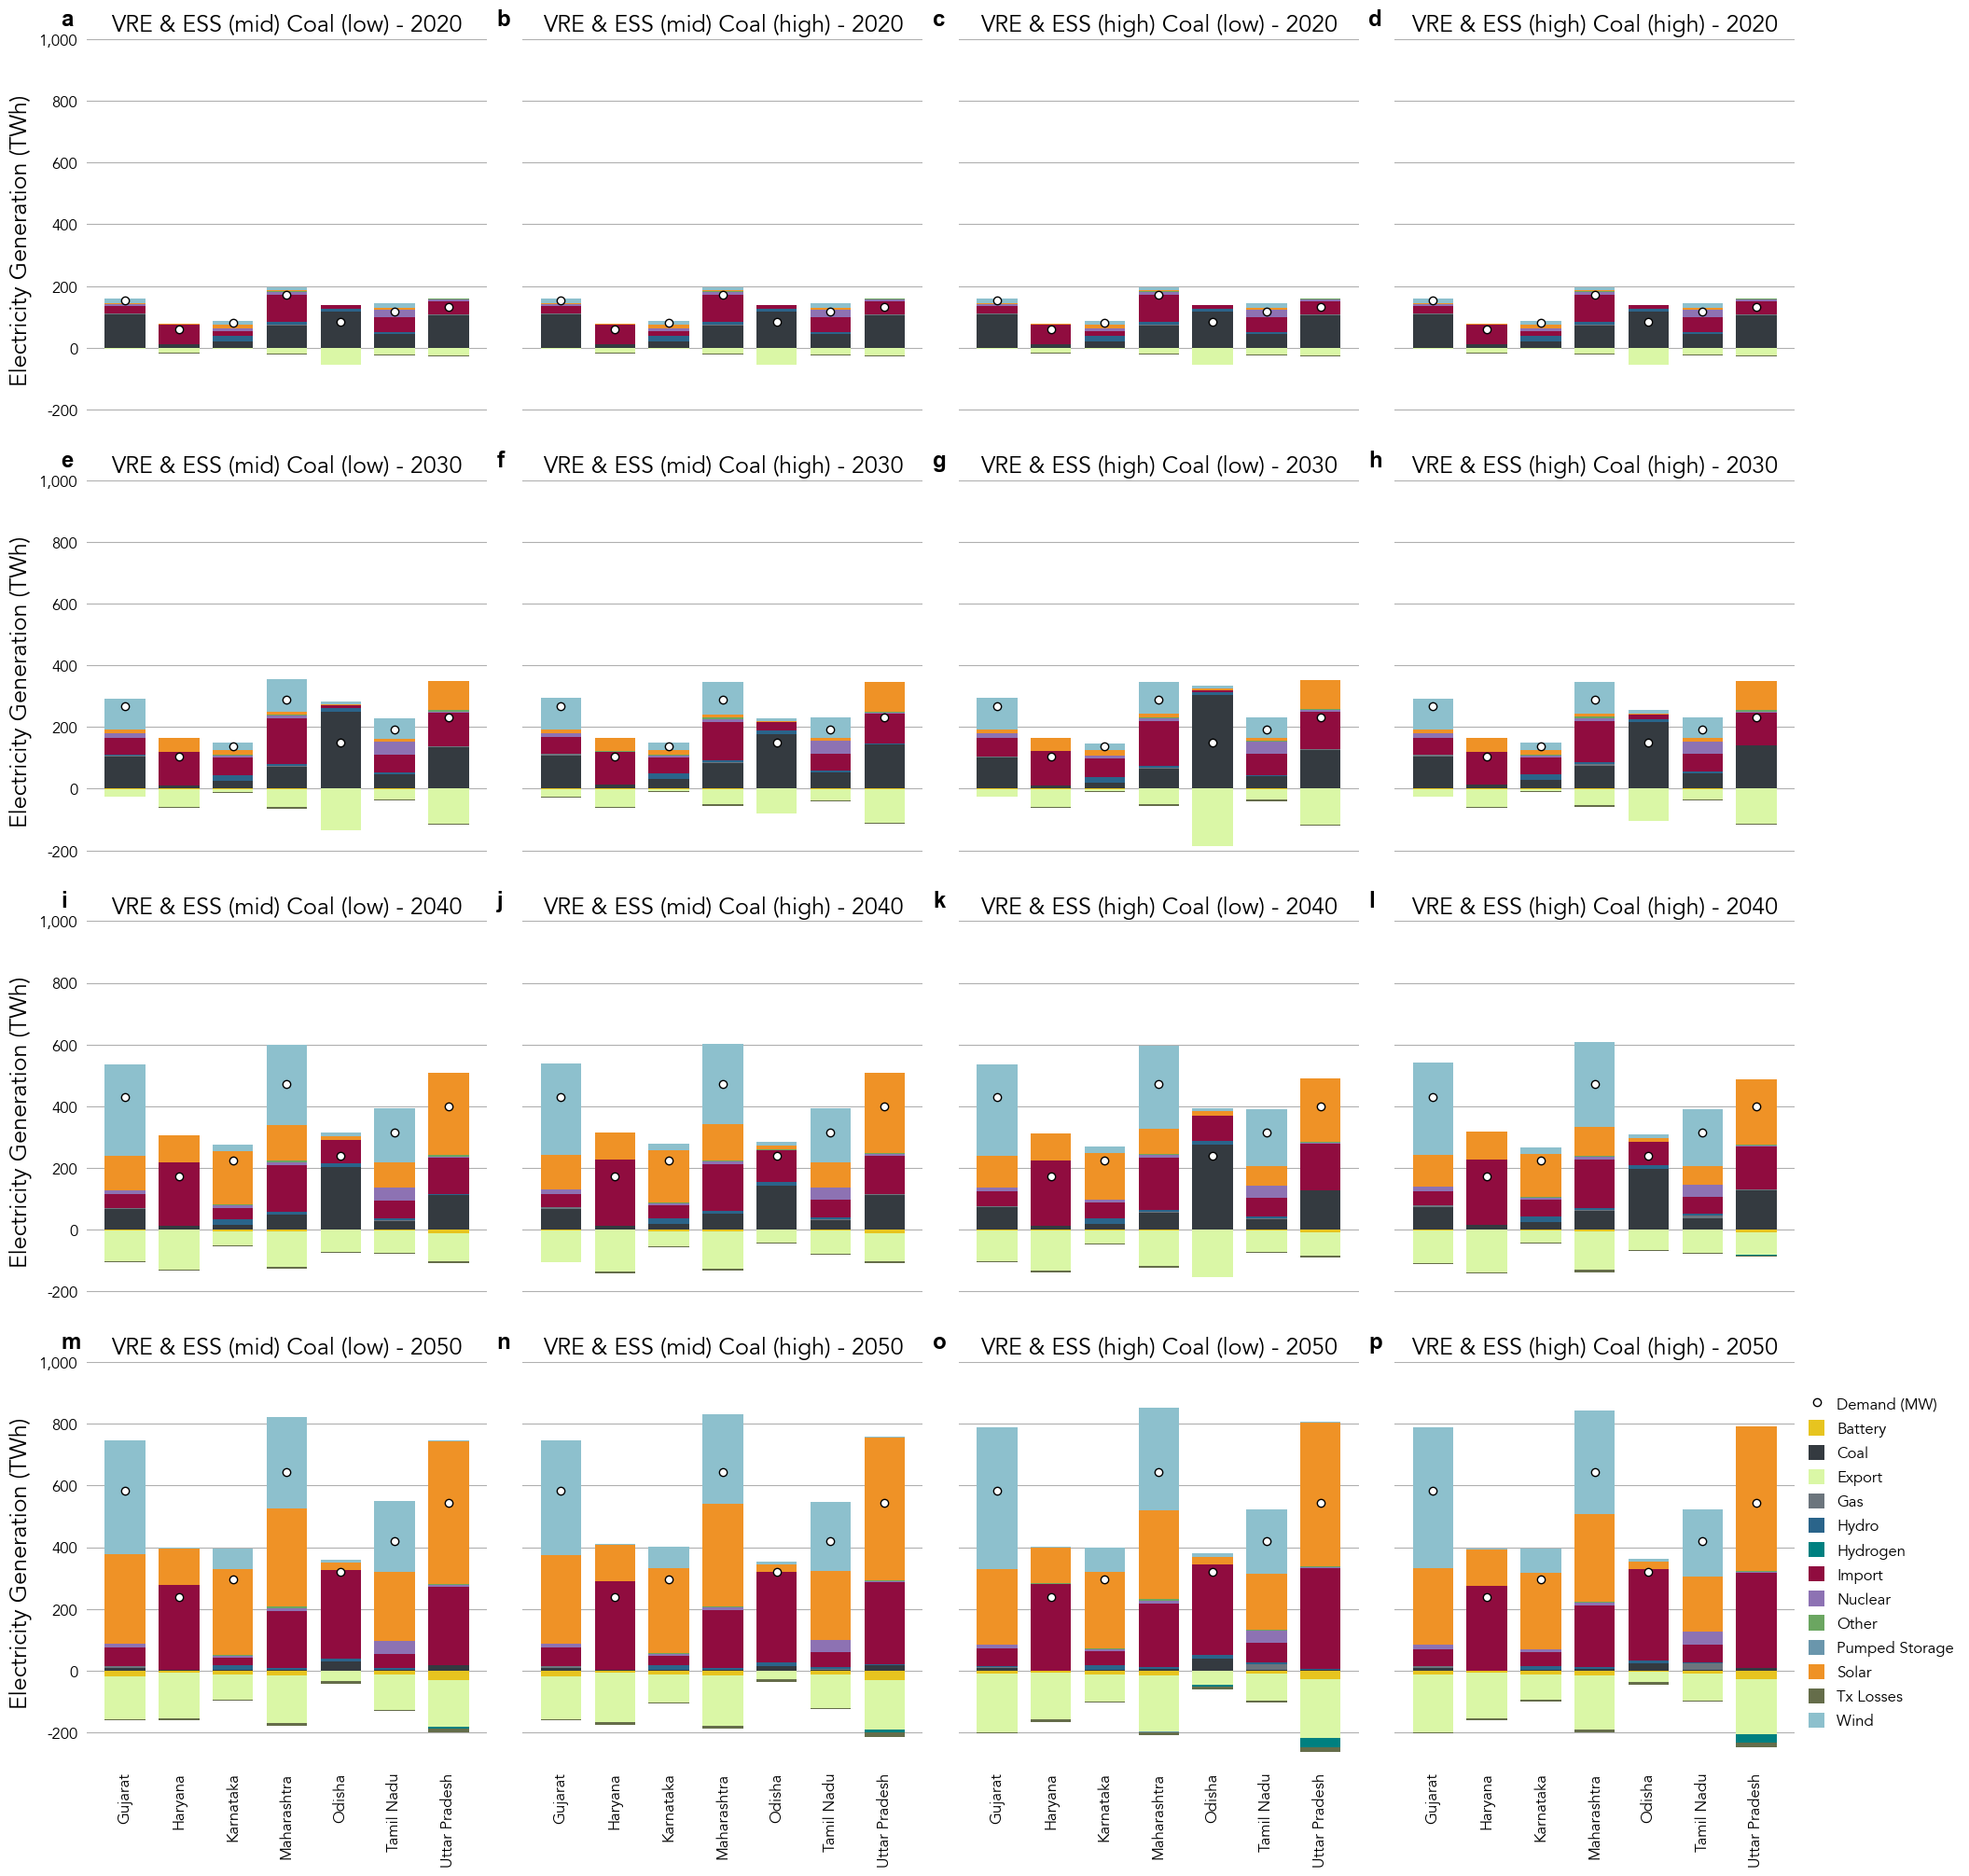

In [142]:
scens_   = zone_labels_['scenario'].dropna().unique()
periods_ = zone_labels_['period'].dropna().unique()
zones_   = zone_labels_['load_zone'].dropna().unique()
letters_ = [list(string.ascii_lowercase)[i*len(scens_):i*len(scens_) + len(scens_)] 
            for period, i in zip(periods_, range(len(periods_)))]

fig, _ax = plt.subplot_mosaic(letters_, layout      = 'constrained', 
                                        sharey      = True,
                                        sharex      = True,
                                        figsize     = (.75*len(letters_[0])*len(zones_), 5*len(letters_)), 
                                        gridspec_kw = {'width_ratios': [1]*len(letters_[0])})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

n      = len(letters_)*len(letters_[0])
k      = 1
legend = False

for i in range(len(letters_)):
    for j in range(len(letters_[i])):
        
        if j == 0: 
            ylabel = 'Electricity Generation (TWh)'
        else: 
            ylabel = ''
                    
        if k == n: 
            legend = True
        else:
            k += 1

        label  = scen_labels_.loc[scen_labels_['scenario'] == scens_[j], 'label'].to_numpy()[0]
        period = int(periods_[i])
        
        _plot_dispatch_by_zone(_ax[letters_[i][j]], 
                               group_dispatch_, demand_, tech_labels_, scens_[j], periods_[i],
                               title       = f'{label} - {period}',
                               y_lim_min   = -300,
                               y_lim_max   = 1000,
                               legend      = legend,
                               ylabel      = ylabel)

plt.savefig(path_to_images + f'/zone_dispatch_mwh-bar_plots.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Energy Targets - Renewable Purchage Obligations

In [14]:
scen_labels_ = pd.read_csv(path_to_csvs + '/tech_cost-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 
zone_labels_ = pd.read_csv(path_to_csvs + '/zone_labels.csv') 

In [55]:
rpo_ = _load_energy_target(scen_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power

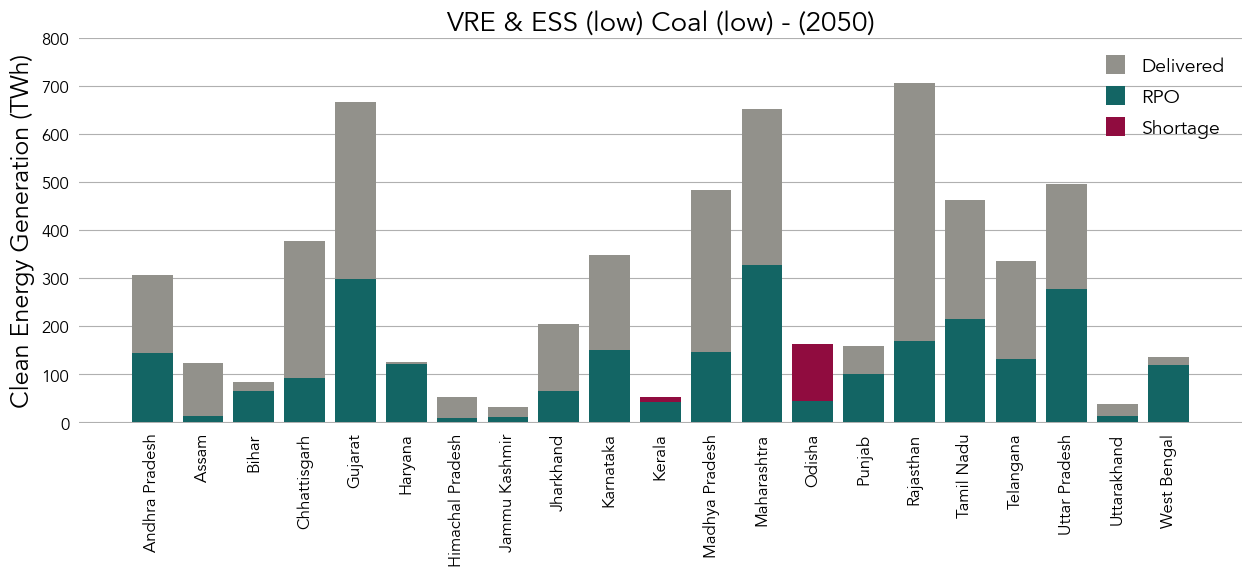

In [ ]:
period = 2050
i_scen = 0

scen  = scen_labels_['scenario'][i_scen]
label = scen_labels_['label'][i_scen]

fig = plt.figure(figsize = (15, 5))
_ax = plt.subplot(111)

_plot_energy_target(_ax, rpo_, scen, period,
                    title  = f'{label} - ({period})',
                    ylabel = 'Clean Energy Generation (TWh)' ,
                    units  = 1e6, 
                    legend = True)
    
plt.savefig(path_to_images + f'/{scen}-{period}-zone_level-RPO.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

# Mosaic

In [ ]:
rpo_ = _load_energy_target(scen_labels_)

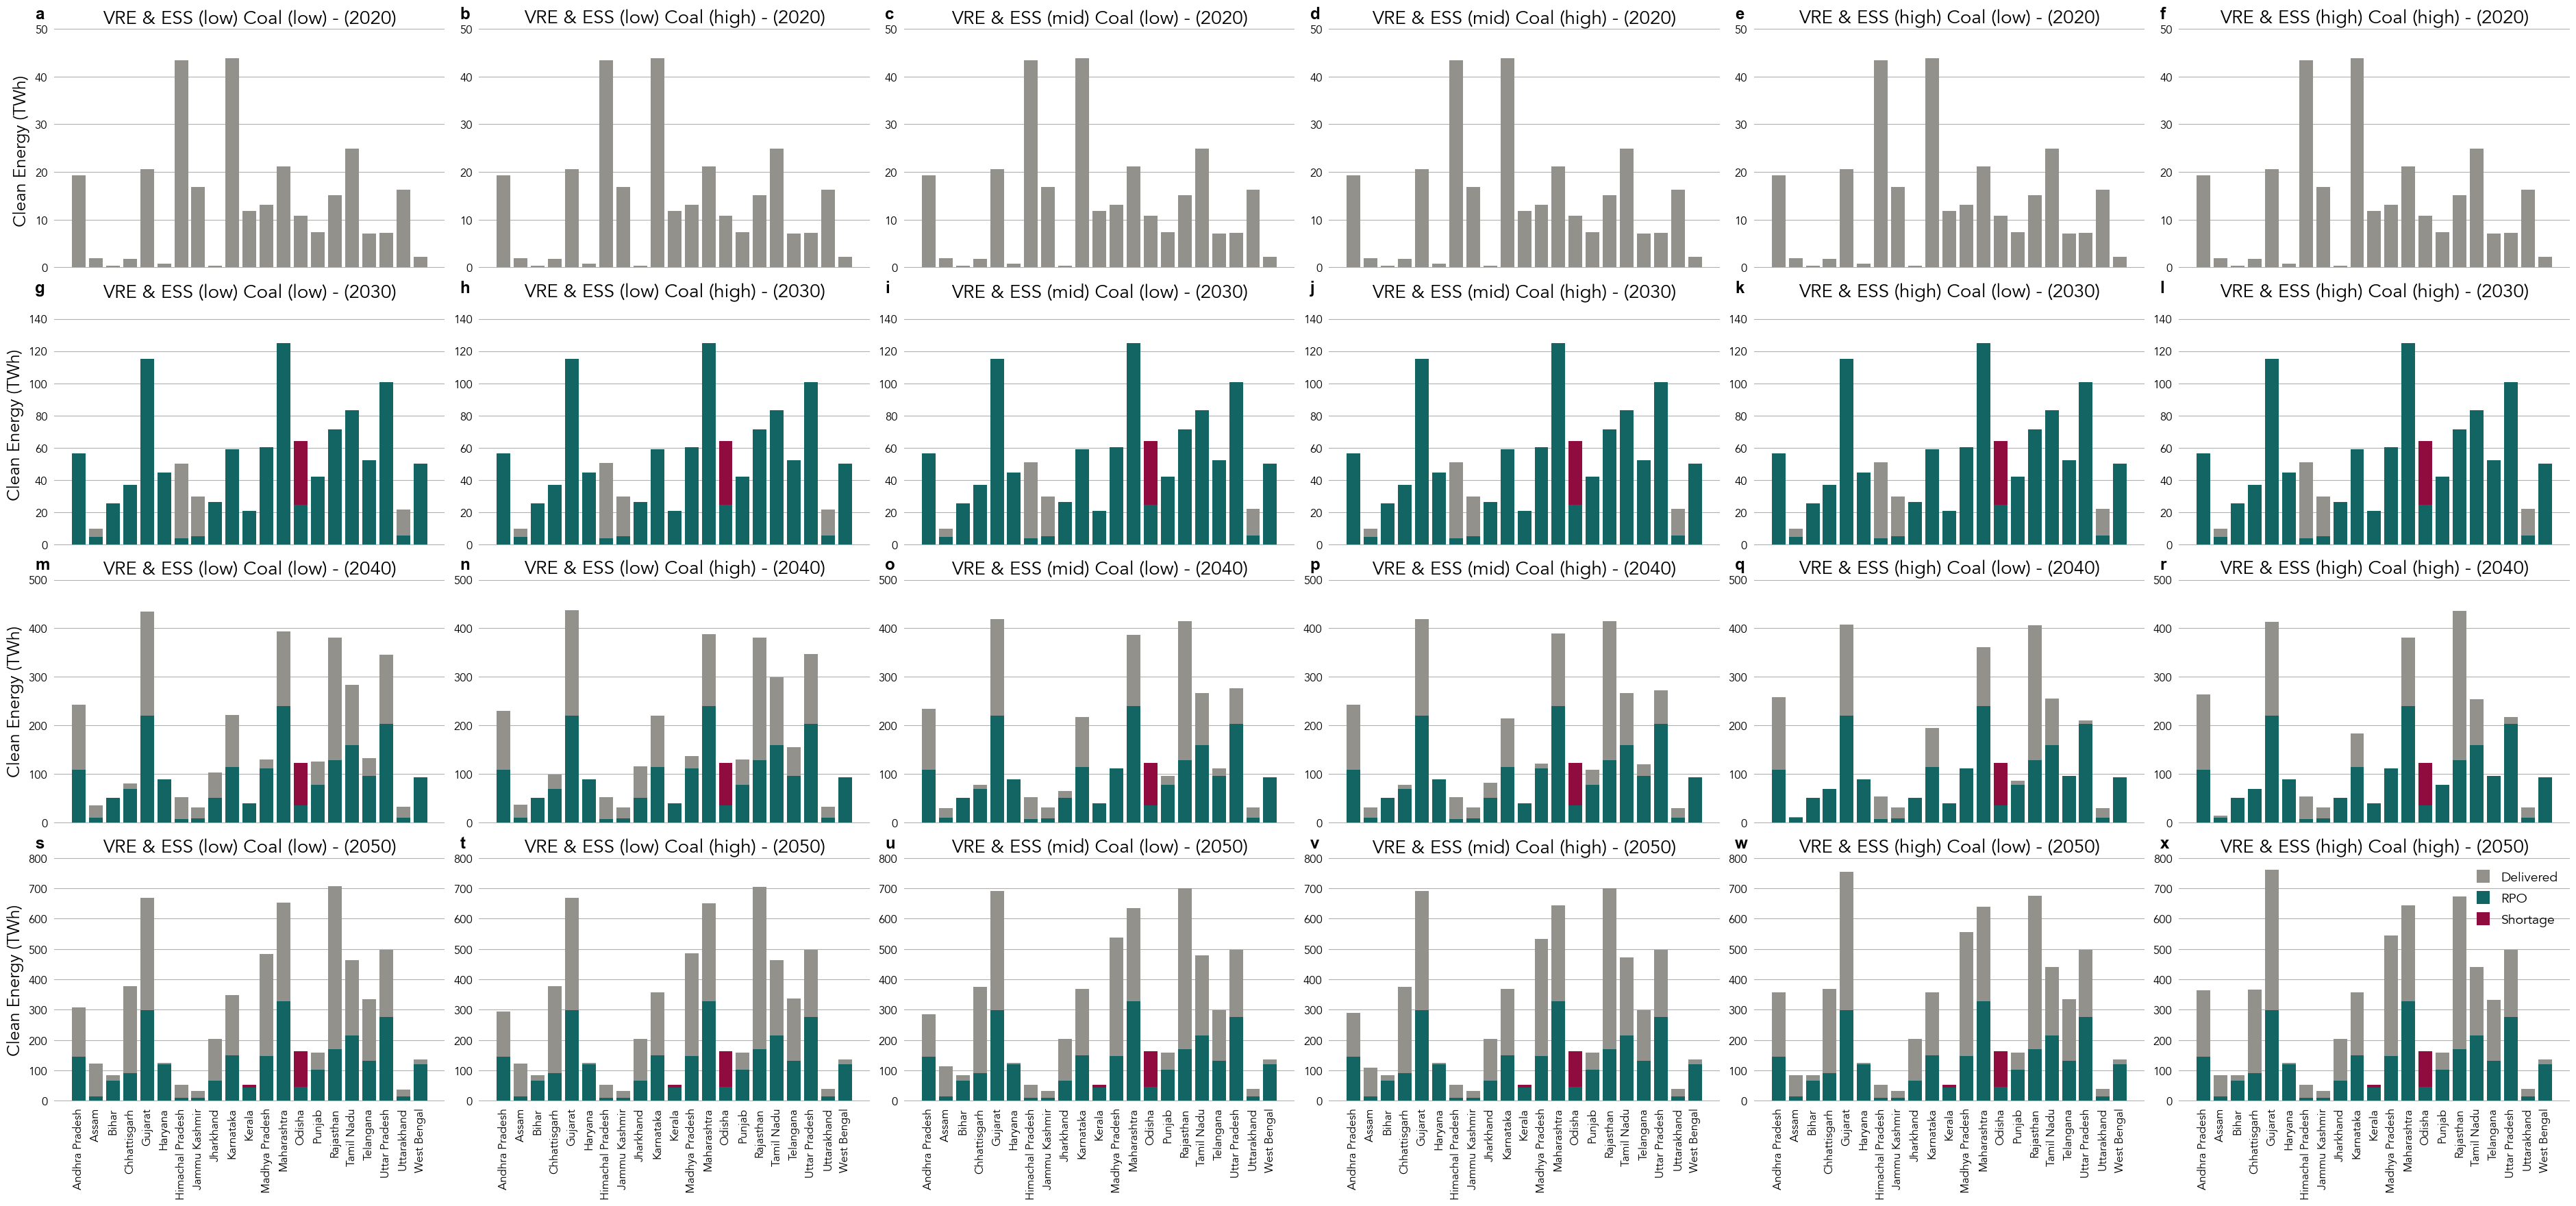

In [137]:
scens_   = scen_labels_['scenario']
periods_ = rpo_['period'].unique()
letters_ = [list(string.ascii_lowercase)[i*len(scens_):i*len(scens_) + len(scens_)] 
            for i in range(len(periods_))]

fig, _ax = plt.subplot_mosaic(letters_, layout      = 'constrained', 
                                        sharex      = True,
                                        figsize     = (37.5, 17.5), 
                                        gridspec_kw = {'width_ratios': [1]*len(letters_[0])})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

n      = len(letters_)*len(letters_[0])
k      = 1
legend = False

for i in range(len(letters_)):
    for j in range(len(letters_[i])):
        
        if j == 0: 
            ylabel = 'Clean Energy (TWh)'
        else: 
            ylabel = ''
                    
        if k == n: 
            legend = True
        else:
            k += 1

        label  = scen_labels_.loc[scen_labels_['scenario'] == scens_[j], 'label'].to_numpy()[0]
        period = int(periods_[i])
        
        _plot_energy_target(_ax[letters_[i][j]], rpo_, scens_[j], periods_[i],
                            title     = f'{label} - ({period})',
                            ylabel    = ylabel,
                            legend    = legend, 
                            y_lim_max = [50, 150, 500, 800][i])
    
plt.savefig(path_to_images + f'/zone_level-RPO.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

In [ ]:
# def _plot_new_and_existing_capacity_by_zone(ax, df_, scens_label_, tech_label_, zone,
#                                             units        = 1e3,
#                                             units_label  = 'Existing & New Capacity (GW)',
#                                             y_period_loc = -1600.,
#                                             y_grid_inc   = 500,
#                                             div_line_len = 0.325,
#                                             legend       = True,
#                                             title        = ''):

#     def __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax):

#         ax.bar(0., 0., 0., bottom    = 0.,
#                            label     = 'Existing',
#                            color     = 'None',
#                            lw        = 0.,
#                            hatch     = 'xx',
#                            edgecolor = 'lightgray',
#                            zorder    = 10)

#         for tech, i_tech in zip(techs_, range(len(techs_))):
#             idx_ = df_['technology'] == tech
#             if idx_.sum() > 0:
#                 if df_.loc[idx_, 'capacity_mw'].sum() != 0:
#                     ax.bar(0., 0., 0., bottom = 0.,
#                                        color  = colors_[i_tech],
#                                        label  = tech,
#                                        zorder = 10)

#     periods_     = np.sort(df_['period'].unique())
#     scens_       = scens_label_['scenario'].unique()    
#     techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
#     colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

#     ticks_    = []
#     labels_   = []
#     offsets_  = []
#     lengths_  = []
#     x_period_ = []
    
#     i_scen = 0
#     offset = 0
#     y_max  = 0
    
#     width  = 1/(len(scens_) + 1)
#     x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
#     for scen, label in zip(scens_label_['scenario'], scens_label_['label']):

#         df_p_ = df_.copy()
#         idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
        
#         for period, i_period in zip(periods_, range(len(periods_))):
#             idx_1_ = idx_ & (df_p_['period'] == period)
#             if (i_scen == 0) & (i_period == 0): 
#                 __make_new_and_existing_capacit_legend(df_p_, techs_, colors_, ax)

#             for tech, i_tech in zip(techs_, range(len(techs_))):
#                 idx_2_ = idx_1_ & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

#                 if idx_2_.sum() == 1.:
#                     power = df_p_.loc[idx_2_, 'capacity_mw'].to_numpy()[0]
#                     color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

#                     ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
#                                                              color     = color,
#                                                              lw        = 0.,
#                                                              hatch     = 'x',
#                                                              edgecolor = 'lightgray', zorder = 10)

#                     offset += power

#             for tech, i_tech in zip(techs_, range(len(techs_))):
#                 idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
#                 if idx_3_.sum() == 1.:
#                     power = df_p_.loc[idx_3_, 'capacity_mw'].to_numpy()[0]
#                     color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

#                     ax.bar(x_[i_period], power/units, width, bottom = offset/units,
#                                                              color  = color,
#                                                              zorder = 10)

#                     offset += power

#             if y_max < offset:
#                 y_max = offset

#             ticks_.append(x_[i_period])
#             labels_.append(label)
#             offsets_.append(offset/units)
#             x_period_.append(x_[i_period])

#             offset = 0.

#         x_ = x_ + .9/len(scens_)
#         i_scen += 1
        
#     z_ = x_ - .9/len(scens_)

#     x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
#     y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
#     for x_period, y_period, period in zip(x_period_, y_period_, periods_):
#         ax.text(x_period, y_period_loc, period, fontsize            = 18, 
#                                                  weight              = 'bold',
#                                                  horizontalalignment = 'center', 
#                                                  verticalalignment   = 'center')

#     x_ = np.linspace(0, len(periods_), len(periods_) + 1)
#     dz = (x_[1] - z_[0])
#     for x in x_:
#         ax.axvline(x - dz/2., ymin      = 0.,
#                               ymax      = - div_line_len,
#                               linewidth = .75,
#                               linestyle = '-',
#                               color     = 'k',
#                               clip_on   = False,
#                               zorder    = 10)

#     N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
#     y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

#     ax.set_xticks(ticks_, labels_, rotation = 90)

#     ax.xaxis.set_tick_params(labelsize = 12, 
#                              left      = False)
    
#     ax.yaxis.set_tick_params(labelsize = 12, 
#                              left      = False)

#     ax.set_ylabel(units_label, fontsize = 18)
#     ax.set_yticks(y_ticks_, y_ticks_)

#     if legend:
#         ax.legend(loc            = 'center left',
#                   bbox_to_anchor = (1, 0.5),
#                   frameon        = False,
#                   prop           = {'size': 12})

#     ax.set_ylim(-10., y_period_.max()*1.2)
#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.set_title(title, fontsize = 20,
#                      y        = 0.912)

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
#     ax.grid(axis = 'y')
    
# zone = 'Andhra_Pradesh'

# fig = plt.figure(figsize = (12.5, 10))
# _ax = plt.subplot(111)

# _plot_new_and_existing_capacity_by_zone(_ax, group_capacity_, scen_labels_, tech_labels_, zone,
#                                         units_label = 'Existing & New Capacity (GW)',
#                                         y_period_loc = -95,
#                                         y_grid_inc   = 25,
#                                         div_line_len = 0.325)

# plt.savefig(path_to_images + f'/{zone}_installed_mw.png', bbox_inches = 'tight', 
#                                                           dpi         = 600)
# plt.show()